In [231]:
import xarray as xr
import numpy as np
from stompy.plot import nbviz, plot_wkb, plot_utils
from stompy.grid import unstructured_grid
from stompy.spatial import wkb2shp
from stompy import utils, filters, memoize
import shlex
import pandas as pd
import statsmodels.formula.api as smf

import os
import six
import seaborn as sns
import matplotlib.pyplot as plt
import stompy.model.delft.waq_scenario as dwaq
import stompy.model.delft.io as dio

In [37]:
#%matplotlib notebook

In [38]:
# Might be useful...
hydro = dwaq.HydroFiles(hyd_path="../v148_jun_28_2016_dwaq_merge/com-v148_jun_28_2016_dwaq_merge.hyd")

In [39]:
#run_dir="/home/rusty/src/data_lsb_tracer_00"
#run_dir="./data_lsb_tracer_01b" # only 5 days... output maybe in dwaq2_map
#run_dir="./data_lsb_tracer_01" 
run_dir="./data_lsb_tracer_02" # additional Palo Alto source, maybe better pond tracer values.
map_ds=xr.open_dataset(os.path.join(run_dir,'dwaq_map.nc')) # currently incomplete

In [73]:
# LP advective flux?

# Extract flow manually. Scans the hydro which takes some time.
# Cache results in the waq run directory

def transect_flow(run_dir,hydro,transect_name,force=False):
    cache_dir=os.path.join(run_dir,"cache")
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    cache_basename = f"Q_{transect_name}.nc"
    cache_fn = os.path.join(cache_dir,cache_basename)
    if force or not os.path.exists(cache_fn):
        #hydro = dwaq.HydroFiles(hyd_path="../v148_jun_28_2016_dwaq_merge/com-v148_jun_28_2016_dwaq_merge.hyd")
        inp=dwaq.InpReader(os.path.join(run_dir,'waqmodel.inp'))
        Q=hydro.extract_transect_flow(inp.get_transect_by_name(transect_name))
        Q.name="discharge"
        Q.to_netcdf(cache_fn)
    else:
        Q=xr.load_dataarray(cache_fn)
        
    return Q

In [40]:
g=unstructured_grid.UnstructuredGrid.read_ugrid(map_ds)
shore=g.boundary_polygon()
tri,tri_srcs=g.mpl_triangulation(return_sources=True)
if 0:
    fig,ax=plt.subplots(figsize=(9.5,8))
    ax.set_adjustable('datalim')
    g.plot_edges(color='k',lw=0.5,alpha=0.6)

INFO:join_features:0 open strings, 24 simple polygons
INFO:join_features:Building index
/home/rusty/src/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
/home/rusty/src/stompy/stompy/spatial/join_features.py:516: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  index=STRtree(simple_polys)
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3242487807.773357, 23 potential interiors


<IPython.core.display.Javascript object>


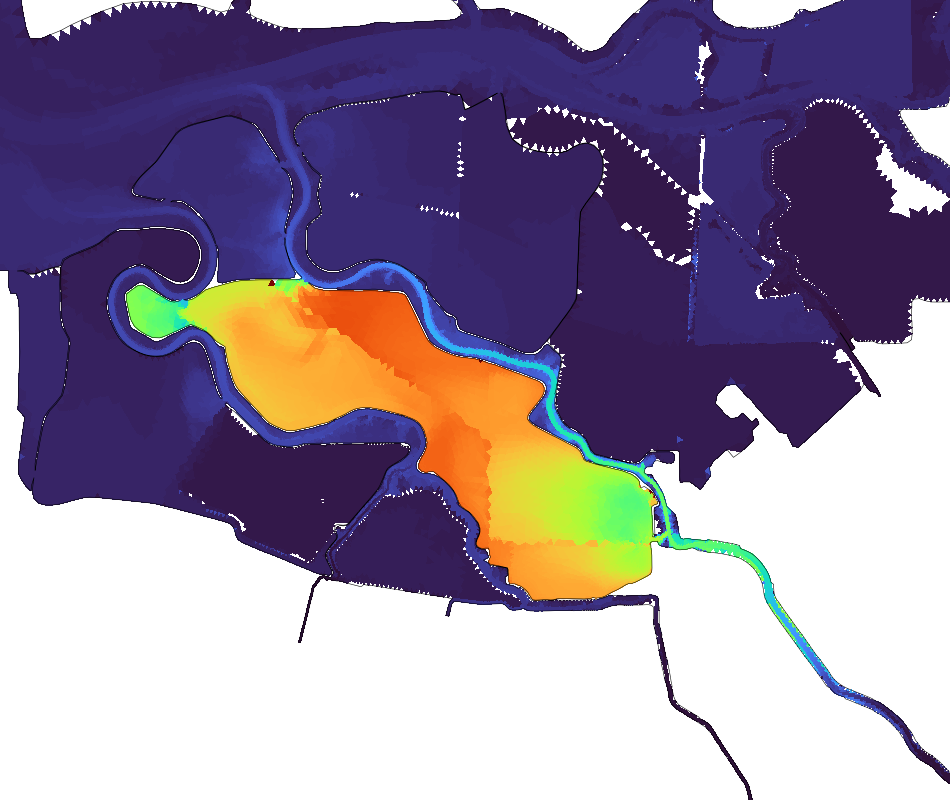

(576015.0, 593479.0, 4140885.0, 4152402.0)

In [297]:
fig,ax=plt.subplots(figsize=(9.5,8))

scal=map_ds.pond_chl.isel(layer=0,time=-1)

dry=scal==-999

tri_scalar=scal[tri_srcs]
ax.tripcolor(tri,facecolors=scal[tri_srcs],cmap='turbo',clim=[0,8])

plot_wkb.plot_wkb(shore,fc='none',ec='k',lw=0.4,zorder=3)

ax.set_position([0,0,1,1])
ax.axis('off')
ax.axis('equal')
ax.axis( (576015., 593479., 4140885., 4152402.))

In [311]:
map_ds

<xarray.Dataset>
Dimensions:     (sub: 9, time: 3313, layer: 10, face: 110783, node: 80777,
                 maxnode_per_face: 4, edge: 191582, node_per_edge: 2)
Coordinates:
  * sub         (sub) object 'san_jose' 'san_mateo' ... 'SURF' 'TotalDepth'
  * time        (time) datetime64[ns] 2016-06-28T14:00:00 ... 2016-09-05T14:0...
Dimensions without coordinates: layer, face, node, maxnode_per_face, edge,
                                node_per_edge
Data variables: (12/18)
    t_sec       (time) int32 ...
    san_jose    (time, layer, face) float32 ...
    san_mateo   (time, layer, face) float32 ...
    sunnyvale   (time, layer, face) float32 ...
    palo_alto   (time, layer, face) float32 ...
    pond_chl    (time, layer, face) float32 ...
    ...          ...
    node_y      (node) float64 4.197e+06 4.199e+06 ... 4.147e+06 4.147e+06
    face_node   (face, maxnode_per_face) int32 0 1 2 3 ... 46482 80774 46868 -1
    edge_node   (edge, node_per_edge) int32 0 1 1 2 ... 46868 80774 80774 46482
    bedlevel    (face) float32 -87.21 -86.68 -81.41 ... -1.215 -1.215 -1.215
    eta         (time, face) float32 ...
    sigma       (layer) float64 ...
Attributes:
    header:   DWAQ                                    n/a                    ...

<IPython.core.display.Javascript object>


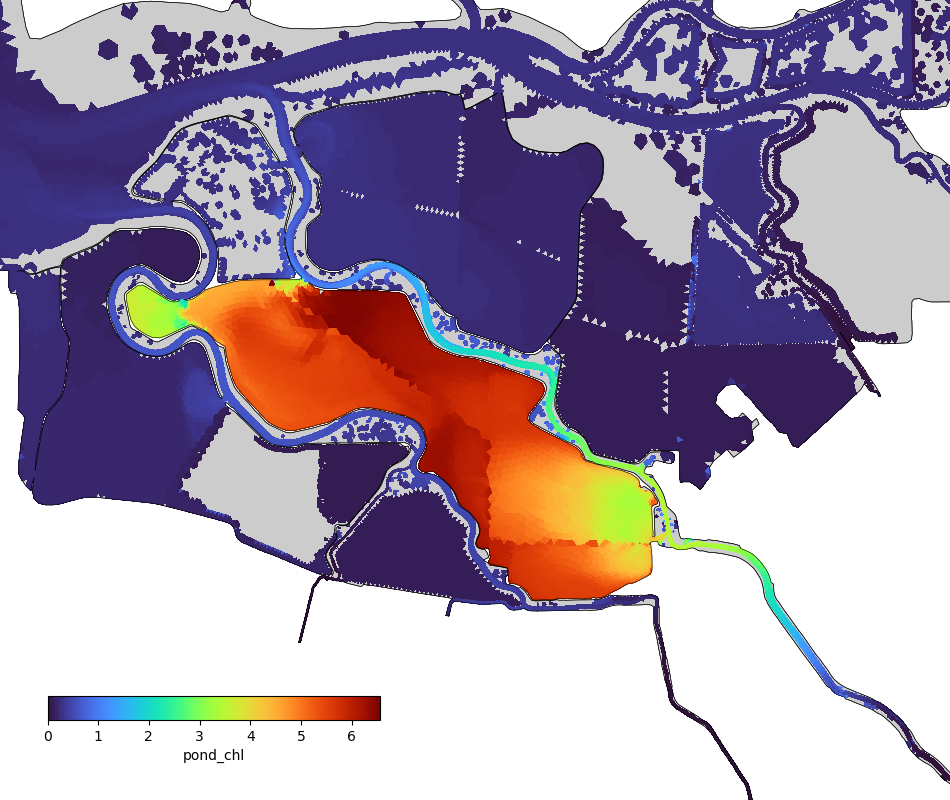

<IPython.core.display.Javascript object>


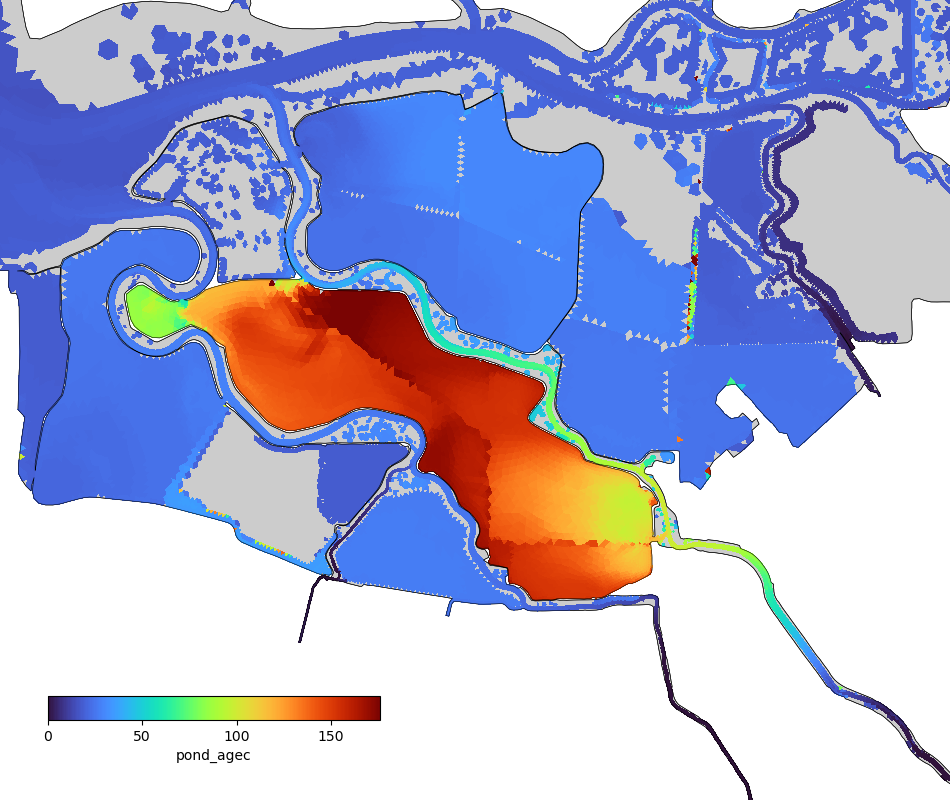

<IPython.core.display.Javascript object>


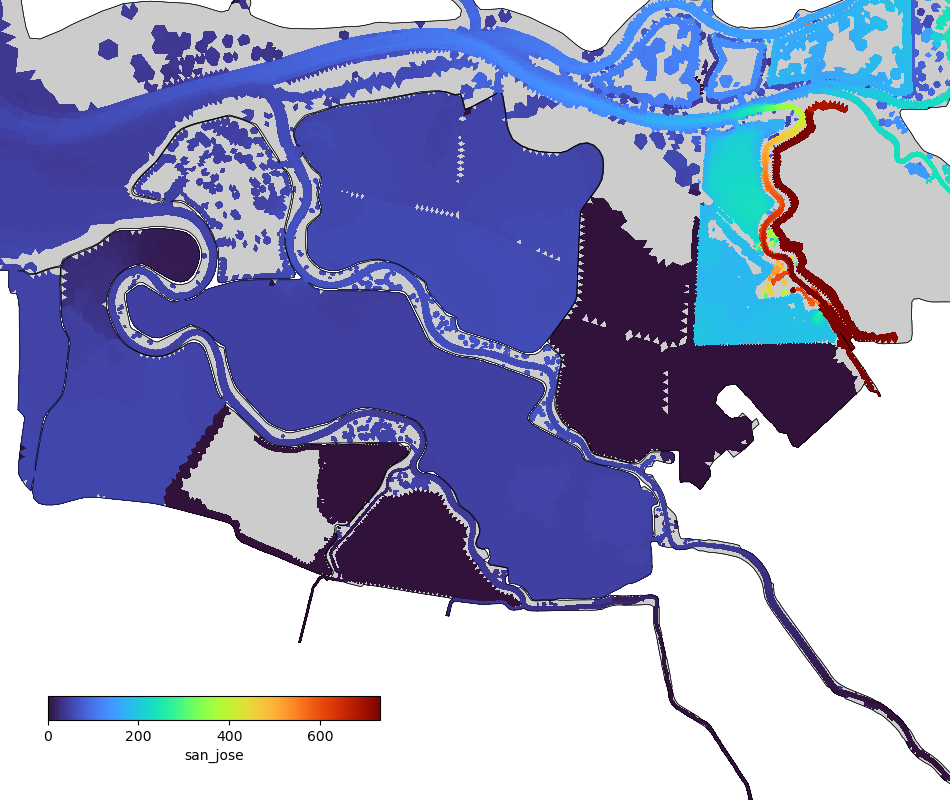

In [316]:
# In-pond distribution of concentration
zoom=(583787., 593113., 4139756., 4147609.)
cell_in_zoom=g.cell_clip_mask(zoom)

for field in ['pond_chl','pond_agec','san_jose']:
    fig,ax=plt.subplots(figsize=(9.5,8))

    scal=map_ds[field].isel(layer=0,time=-1)
    dry=map_ds['LocalDepth'].isel(layer=0,time=-1).values<0.01
    scal=np.where(dry,np.nan,scal)
    
    cmax=1.2*np.percentile(scal[np.isfinite(scal)&cell_in_zoom],94)
    
    tri_scalar=scal[tri_srcs]
    coll=ax.tripcolor(tri,facecolors=scal[tri_srcs],cmap='turbo',clim=[0,cmax])

    plot_wkb.plot_wkb(shore,fc='0.8',lw=0.4,zorder=-1)
    plot_wkb.plot_wkb(shore,fc='none',ec='k',lw=0.4,zorder=3)

    ax.set_position([0,0,1,1])
    ax.axis('off')
    ax.axis('equal')
    ax.axis( zoom)
    cax=fig.add_axes([0.05,0.1,0.35,0.03])
    plt.colorbar(coll,cax=cax,label=field,orientation='horizontal')


Flux Analysis
==

In [42]:
hist_ds = xr.open_dataset(os.path.join(run_dir,'dwaq_hist.nc'))

In [217]:
# For instance, relate flux at alv2 (ALV moored sensor)
# to the concentrations at alv1 (upstream) and alv3 (downstream).

class FluxAnalysis:
    flux_station ='alv2'
    up_station   = 's_alv1'
    mid_station  ='s_alv2'
    down_station ='s_alv3'
    scalar='san_jose'
    norm=None # 'lp_gradient' normalize so lp gradient has rms of 1.0 
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)

    @property
    @memoize.imemoize()
    def scale(self):
        """ A factor to scale flux-gradient data to unit range.
        This is automatically applied in plotting, but not directly
        to any data.
        """
        if self.norm is None: return 1.0
        if self.norm=='lp_gradient':
            rms=np.sqrt(np.mean(self.lp(self.gradient())**2))
            return 1.0/max(1e-6,rms)
        assert False

    def flux_values(self):
        # ostensibly downstream-directed, but 50/50 change I got signs correct.
        # DWAQ values are period-integrated. convert to a rate.
        return hist_ds.bal.sel(field=self.scalar,region=self.flux_station) / self.dt_s()
    def QC_flux_values(self):
        return self.conc_values() * self.discharge()
    def QbarCbar_flux_values(self):
        return self.lp(self.conc_values()) * self.lp(self.discharge())
    
    def lp_disp_flux_values(self):
        return self.lp(self.QC_flux_values()) - self.QbarCbar_flux_values()
    
    def dt_s(self):
        return np.median( np.diff( hist_ds.time.values ) /np.timedelta64(1,'s') )
    
    def lp(self,v):
        try:
            v=v.values
        except AttributeError:
            pass
        return filters.lowpass_godin(v,mean_dt_h=self.dt_s()/3600.0)

    def spring_neap(self,v,standard=True):
        "RMS amplitude filter for spring-neap indicator"
        try:
            v=v.values
        except AttributeError:
            pass
        prime=v-self.lp(v)
        result = np.sqrt( self.lp(prime**2) )
        trim_samples = int( (36.0 * 3600) / self.dt_s() )
        result[:trim_samples]  = result[ trim_samples]
        result[-trim_samples:] = result[-trim_samples]
        
        if standard:
            result = (result-result.mean())/np.std(result)
        return result

    def conc_values(self):        
        return hist_ds.bal.sel(field=self.scalar,region=self.mid_station)
    def conc_up_values(self):
        return hist_ds.bal.sel(field=self.scalar,region=self.up_station)
    def conc_dn_values(self):
        return hist_ds.bal.sel(field=self.scalar,region=self.down_station)
    def gradient(self):
        return self.conc_up_values() - self.conc_dn_values()

    def discharge(self):
        Q = transect_flow(run_dir,hydro,transect_name=self.flux_station)
        # I think that for a given time, Q from the hydro is the flow in the following
        # interval, while the history output reflects the previous interval.
        # If nothing else, this adjustment gets the dwaq flux and Q*C flux into agreement.
        Q_dt = np.median(np.diff(Q.time))
        return np.interp( hist_ds.time, Q.time+Q_dt, Q.values )

    def depth(self):
        # Generally have LocalDepth in the history output, but
        # it's the *sum* of depths of the lower bound of segments.
        # Station output is set to be a single watercolumn.
        Nlayers=int(hydro.hyd_toks['number-hydrodynamic-layers'])

        # localdepth=  dz * sum_{k=1..N} k = dz * (N+1)N/2
        # H = dz*N = localdepth * 2 / (N+1) 
        localdepth=hist_ds.bal.sel(field='LocalDepth',region=self.mid_station).values
        return 2*localdepth/(Nlayers+1)
    
    def df(self,normalize=True):
        df=pd.DataFrame()
        scale=self.scale if normalize else 1.0
        df['time']=hist_ds.time
        df['scalar']=self.scalar
        df['lp_gradient']=scale * self.lp(self.gradient())
        df['lp_flux']=scale*self.lp(self.flux_values())
        df['disp_flux']=scale*self.lp_disp_flux_values()
        df['sn_Q'] = self.spring_neap(self.discharge())
        df['sn_H'] = self.spring_neap(self.depth())
        return df
        
    def plot_timeseries(self,spring_neap=True,lp_only=True):
        fig,axs=plt.subplots(2,1,sharex=True,figsize=[8.5,5])

        ax_J,ax_C = axs

        ymin=1e6
        ymax=-1e6
        
        if not lp_only:
            #ax_J.plot( hist_ds.time, self.scale * self.flux_values(), label="DWAQ flux")
            y=self.scale * self.QC_flux_values()
            ax_J.plot( hist_ds.time, y,alpha=0.4,lw=0.5,label="QC")
            ymin=min(ymin,y.min())
            ymax=max(ymax,y.max())
            
        y=self.scale * self.lp(self.QC_flux_values())
        ax_J.plot( hist_ds.time, y,label="<QC>")
        ymin=min(ymin,y.min())
        ymax=max(ymax,y.max())

        y=self.scale * self.QbarCbar_flux_values()
        ax_J.plot( hist_ds.time, y,label="<Q><C>")
        ymin=min(ymin,y.min())
        ymax=max(ymax,y.max())

        y=self.scale * self.lp_disp_flux_values()
        ax_J.plot( hist_ds.time, y,label="<Q'C'>")        
        ymin=min(ymin,y.min())
        ymax=max(ymax,y.max())

        ax_C.plot( hist_ds.time, self.scale * self.conc_up_values(),label=f'up ({self.up_station})')
        ax_C.plot( hist_ds.time, self.scale * self.conc_dn_values(),label=f'dn ({self.down_station})')
        #ax_C.plot( hist_ds.time, self.scale * self.conc_values(),label=f'mid ({self.mid_station})')

        ax_C.legend(loc='upper left')        
        ax_C.set_ylabel(f'Conc {self.scalar}')
        ax_J.set_ylabel(f'Flux {self.scalar}')
        
        ax_J.set_ylim(ymin,ymax)
        
        fig.autofmt_xdate()

        if spring_neap:
            leg_x=1.07
            fig.subplots_adjust(right=0.75)
            ax2=ax_J.twinx()

            ax_J.legend(loc='upper left',bbox_to_anchor=[leg_x,1],frameon=0)
            
            # Flow-based spring-neap indicator
            Qspring_neap = fa.spring_neap(fa.discharge())
            Hspring_neap = fa.spring_neap(fa.depth())
            ax2.plot(hist_ds.time, Qspring_neap,color='m',ls='--',label='Spring-neap ~ Q')
            ax2.plot(hist_ds.time, Hspring_neap,color='y',ls='--',label='Spring-neap ~ H')
            ax2.legend(bbox_to_anchor=[leg_x,0],loc='lower left',frameon=False)
        else:     
            ax_J.legend(loc='upper left')        
            fig.subplots_adjust(right=0.97,bottom=0.14,top=0.96)
        return fig
    
    def plot_scatter(self):
        fig,ax=plt.subplots(figsize=(5,4))
        ax.set_xlabel('Gradient')
        ax.set_ylabel('Flux')
        #self.add_inst_scatter(ax=ax)
        self.add_lp_scatter(ax=ax)
        ax.legend(loc='upper left')
        ax.axhline(0,color='k',lw=0.5)
        ax.axvline(0,color='k',lw=0.5)
        fig.subplots_adjust(left=0.16,top=0.97,right=0.97)
        return fig
    
    def add_inst_scatter(self,ax):
        ax.plot( self.scale*self.gradient(), self.scale*self.flux_values(),
                '.', ms=2, alpha=0.4, label=f'Inst. {self.scalar}')
        
    def add_lp_scatter(self,ax,set_limits=True,disp=True,total=True):
        grad_lp=self.scale*self.lp(self.gradient())
        if total:
            flux_lp=self.scale*self.lp(self.flux_values())
            ax.plot( grad_lp, flux_lp, '.', label=f'LP {self.scalar}')
            xxyy=[ grad_lp.min(), grad_lp.max(), flux_lp.min(), flux_lp.max()]
        if disp:
            disp_lp=self.scale*self.lp_disp_flux_values()
            ax.plot( grad_lp, disp_lp, '.', label=f"<Q'C'> {self.scalar}")        
            xxyy=[ grad_lp.min(), grad_lp.max(), disp_lp.min(), disp_lp.max()]

        if set_limits and (disp or total):
            ax.axis( utils.expand_xxyy(xxyy,0.1) )
    

<IPython.core.display.Javascript object>


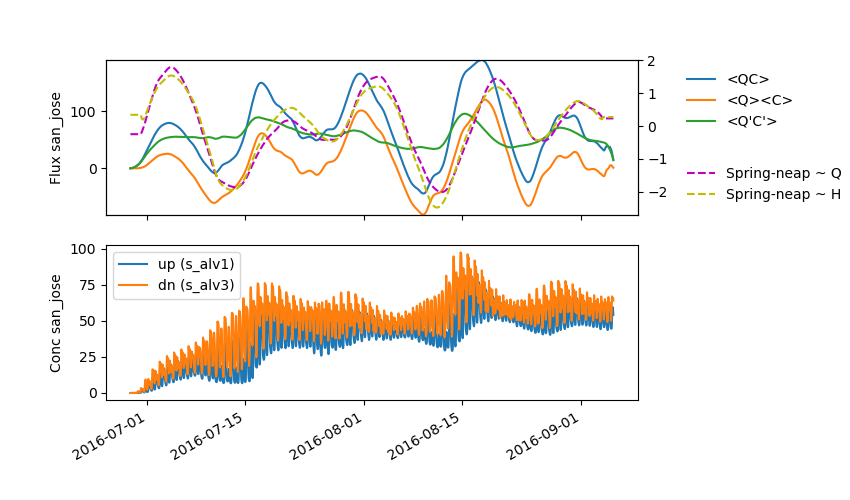

In [216]:
fa=FluxAnalysis(scalar='san_jose')
fig=fa.plot_timeseries()
#fig=fa.plot_scatter()


/tmp/ipykernel_43472/3906993484.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs=plt.subplots(2,1,sharex=True,figsize=[8.5,5])


<IPython.core.display.Javascript object>


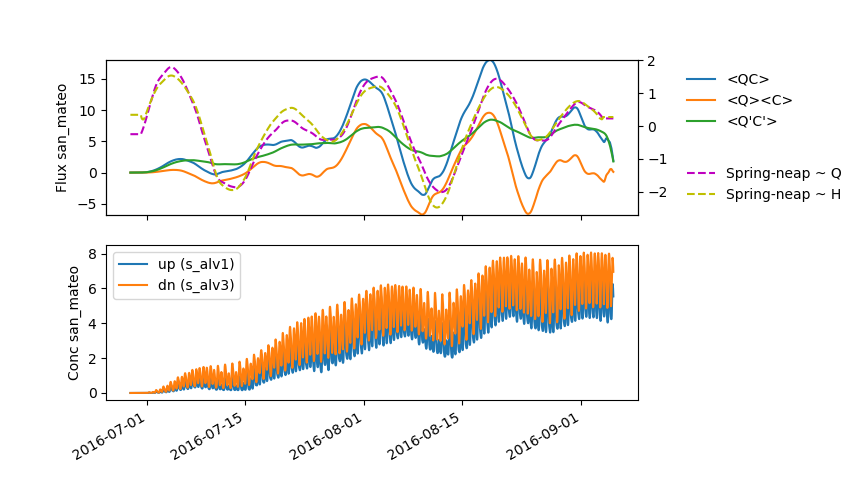

<IPython.core.display.Javascript object>


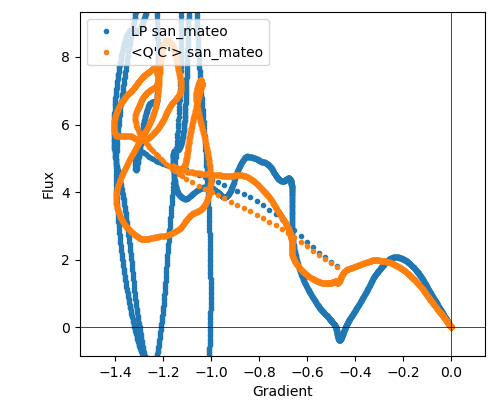

In [218]:
fa=FluxAnalysis(scalar='san_mateo',norm='lp_gradient')
fig=fa.plot_timeseries()
fig=fa.plot_scatter()


/tmp/ipykernel_43472/1479178767.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs=plt.subplots(2,1,sharex=True,figsize=[8.5,5])


<IPython.core.display.Javascript object>


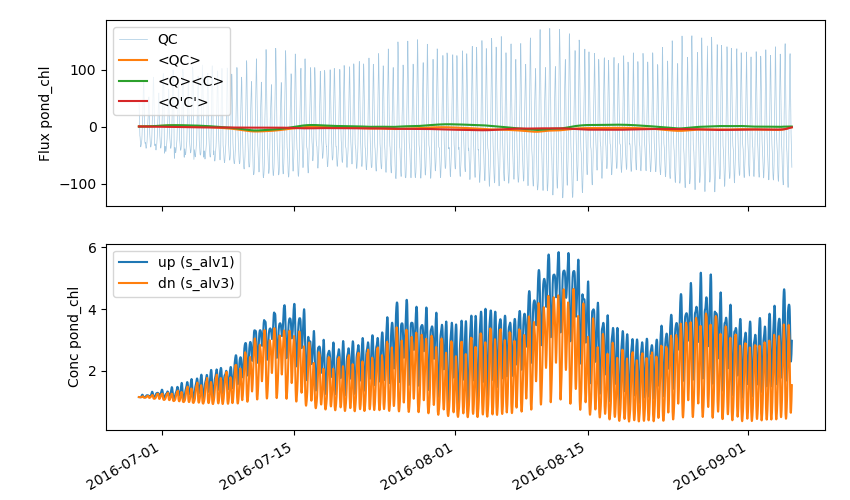

<IPython.core.display.Javascript object>


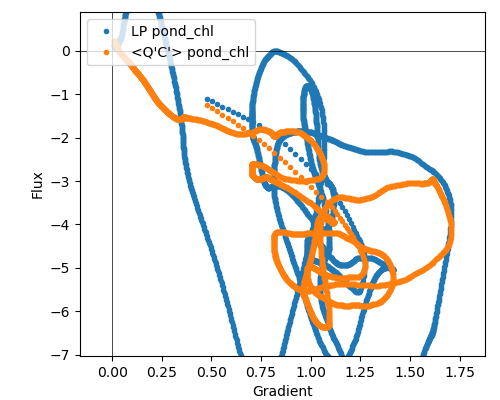

In [145]:
fa=FluxAnalysis(scalar='pond_chl',norm='lp_gradient')
fig=fa.plot_timeseries()
fig=fa.plot_scatter()


/tmp/ipykernel_43472/1479178767.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs=plt.subplots(2,1,sharex=True,figsize=[8.5,5])


<IPython.core.display.Javascript object>


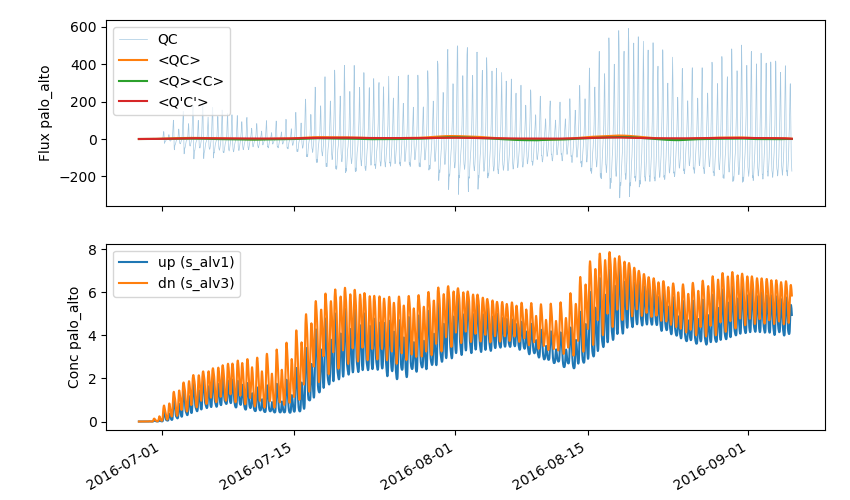

<IPython.core.display.Javascript object>


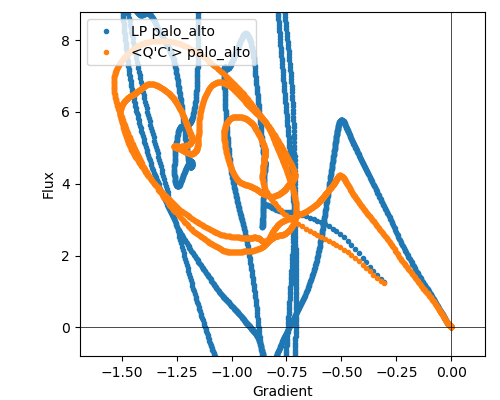

In [146]:
fa=FluxAnalysis(scalar='palo_alto',norm='lp_gradient')
fig=fa.plot_timeseries()
fig=fa.plot_scatter()

/tmp/ipykernel_43472/3204478927.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(figsize=(7,5))


<IPython.core.display.Javascript object>


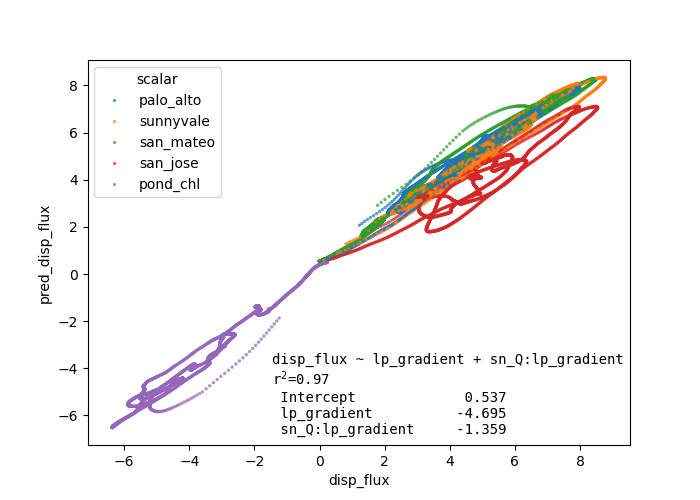

In [274]:
class GroupFluxAnalysis:
    scalars=['pond_chl','san_jose','san_mateo','sunnyvale','palo_alto']

    flux_station ='alv2'
    up_station   = 's_alv1'
    mid_station  ='s_alv2'
    down_station ='s_alv3'
        
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        
        fa_kws=dict(norm='lp_gradient',flux_station=self.flux_station, up_station=self.up_station,
                    mid_station=self.mid_station,down_station=self.down_station)
        self.fas=[FluxAnalysis(scalar=scalar,**fa_kws) for scalar in self.scalars]

    def df(self):
        dfs=[]
        for fa in self.fas:
            df=fa.df()
            df['scalar']=fa.scalar
            dfs.append(df)
        return pd.concat(dfs)
            
    def plot_scatter(self,disp=True):
        fig,ax = plt.subplots(figsize=(7,5))

        for fa in self.fas:
            fa.add_lp_scatter(ax,set_limits=False,disp=disp,total=not disp)

        [fn(0,color='k',lw=0.5) for fn in [ax.axvline,ax.axhline]]
        
        self.add_fit(ax=ax,disp=disp)

        ax.legend(loc='upper right',frameon=0)
        ax.set_xlabel('Gradient')
        ax.set_ylabel('Flux')
        return fig
    
    def plot_fit(self,formula="disp_flux ~ lp_gradient + sn_Q:lp_gradient"):
        # additionally including sn_Q by itself makes almost no improvement. 
        fig,ax = plt.subplots(figsize=(7,5))

        df=self.df().copy()
        
        df=df.sample(frac=1) # otherwise the last scalar is purely on top of the others
        
        result = smf.ols(formula,data=df).fit()
        self.result=result
        df['pred_disp_flux']=result.predict(exog=df)
        
        sns.scatterplot(data=df,x='disp_flux',y='pred_disp_flux',
                        hue='scalar',lw=0,s=6,ax=ax, alpha=0.7)

        lines=[formula, 
               f"r$^2$={result.rsquared:.2f}"]
        for k,v in zip(result.params.index,result.params.values):
            lines.append( f" {k:19}  {v: .3f}")
        annot="\n".join(lines)

        ax.text(0.34,0.02,annot,va='bottom',transform=ax.transAxes, family='monospace')
        return fig
    
    def add_fit(self,ax,disp=True):
        df=self.df()
        if disp:
            formula="disp_flux ~ lp_gradient"
        else:
            formula="lp_flux ~ lp_gradient"
            
        result = smf.ols(formula,data=df).fit()
        df_ordered=df.sort_values('lp_gradient')
        y_ordered=result.predict(exog=df_ordered)
        ls=ax.plot(df_ordered['lp_gradient'],y_ordered,'k-',label='Fit')
        
        annot=f"r$^2$={result.rsquared:.2f}"
        plot_utils.annotate_line(ls[0],annot,ax=ax,buff=dict(foreground='w',linewidth=3.5),
                                offset_points=15)

gfa=GroupFluxAnalysis()
#fig=gfa.plot_scatter(disp=False) ;
#fig=gfa.plot_scatter(disp=True) ;
fig=gfa.plot_fit() ;


<IPython.core.display.Javascript object>


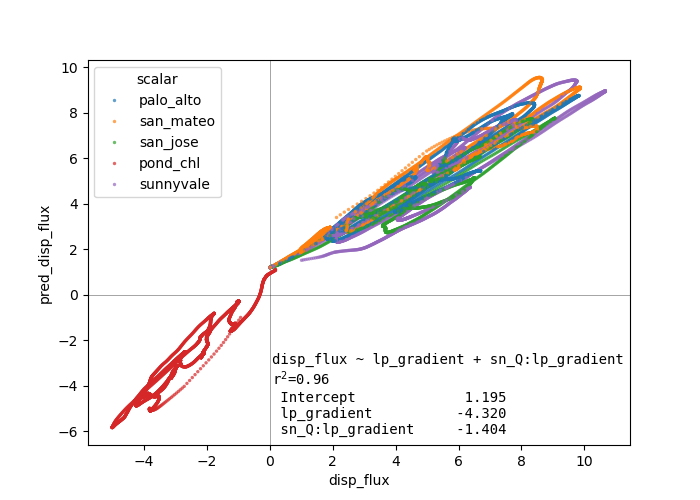

In [287]:
gfa_pond=GroupFluxAnalysis(up_station='s_notch',flux_station='alv1',mid_station='s_alv1',
                           down_station='s_alv2')

fig=gfa_pond.plot_fit()
fig.axes[0].axhline(0,color='k',lw=0.5,alpha=0.5,zorder=-1)
fig.axes[0].axvline(0,color='k',lw=0.5,alpha=0.5,zorder=-1)


<IPython.core.display.Javascript object>


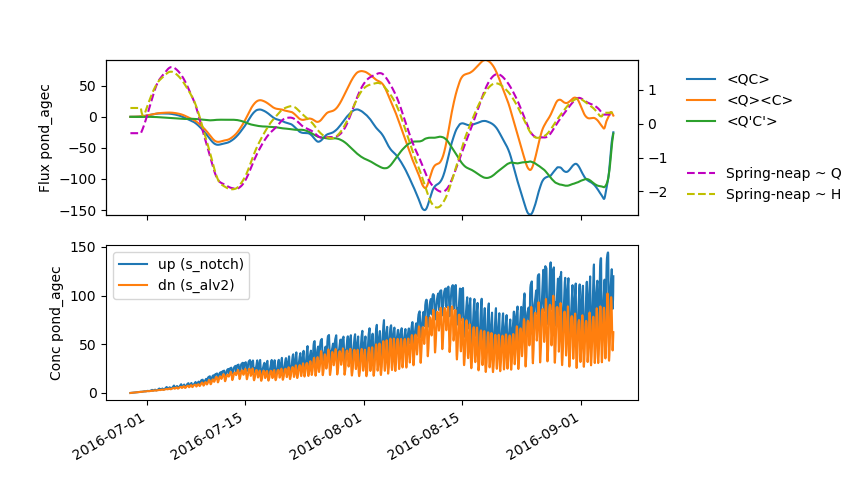

In [285]:
# HERE 
fa=FluxAnalysis(scalar='pond_agec',up_station='s_notch',flux_station='alv1',mid_station='s_alv1',
                           down_station='s_alv2')
fa.plot_timeseries() ;

In [244]:
gfa.result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              disp_flux   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 3.148e+05
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        17:36:47   Log-Likelihood:                -15160.
No. Observations:               16565   AIC:                         3.033e+04
Df Residuals:                   16562   BIC:                         3.035e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5374      0.006     95.738      0.000       0.526       0.548
lp_gradient         -4.6945      0.006   -793.189      0.000      -4.706      -4.683
sn_Q:lp_gradient    -1.3591      0.005   -283.365      0.000      -1.368      -1.350
==============================================================================
Omnibus:                     3122.782   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5342.408
Skew:                           1.246   Prob(JB):                         0.00
Kurtosis:                       4.238   Cond. No.                         2.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [225]:
#formula="disp_flux ~ lp_gradient" # 0.85
#formula="disp_flux ~ lp_gradient + sn_Q" # 0.90
formula="disp_flux ~ lp_gradient * sn_Q"  # 0.976!

formula="disp_flux ~ lp_gradient + lp_gradient : sn_Q" # 0.974 ! 

print(formula)
df=gfa.df()
result = smf.ols(formula,data=df).fit()
df_ordered=df.sort_values('lp_gradient')
y_ordered=result.predict(exog=df_ordered)
ax=fig.axes[0]
ax.plot(df_ordered['lp_gradient'],y_ordered,'k-',label='Fit')

result.summary()

disp_flux ~ lp_gradient + lp_gradient : sn_Q


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              disp_flux   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 3.148e+05
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        17:00:26   Log-Likelihood:                -15160.
No. Observations:               16565   AIC:                         3.033e+04
Df Residuals:                   16562   BIC:                         3.035e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5374      0.006     95.738      0.000       0.526       0.548
lp_gradient         -4.6945      0.006   -793.189      0.000      -4.706      -4.683
lp_gradient:sn_Q    -1.3591      0.005   -283.365      0.000      -1.368      -1.350
==============================================================================
Omnibus:                     3122.782   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5342.408
Skew:                           1.246   Prob(JB):                         0.00
Kurtosis:                       4.238   Cond. No.                         2.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>


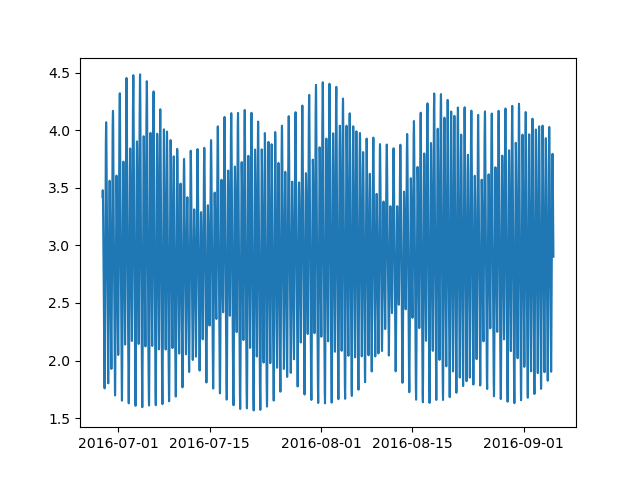

In [193]:
# Should have LocalDepth output. Is that enough to get a tidal signal?
fig,ax=plt.subplots()

ax.plot( hist_ds.time, H )

10

Mid-Run Output
==

Create nc files while the longer run is still going. 

In [36]:
# And the history:
his_fn=os.path.join(run_dir,"waqmodel.his")
hist_ds=dio.his_file_xarray(his_fn)
 

In [132]:
# Balance is only defined for stations / regions. 
bal_fn=os.path.join(run_dir,"waqmodel-bal.his")
bal_ds=dio.his_file_xarray(bal_fn)

In [7]:
# Re-transcribe output 
if False: 
    model=dwaq.WaqModel(base_path="./data_lsb_tracer_01", hydro=hydro)
    print("Writing history")
    model.write_binary_his_nc()
    print("Writing map")
    model.write_binary_map_nc(overwrite=True)
    
if False:
    run_dir="./data_lsb_tracer_01"
    output_fn=os.path.join(run_dir,"tmp-dwaq_map.nc")

    map_fn=os.path.join(run_dir,"waqmodel.map")
    print("Reading map file")
    map_ds=dio.read_map(map_fn,hydro) # 60s?. Adding z takes way too long.
